# Manipulating argument inputs with arithmetic operators

This notebook shows how to manipulate outputs of DALI Operators and use the results as argument inputs allowing to parametrize the Operators in more flexible way.

## Resizing images based on their sizes

We will create a pipeline that will obtain the sizes of all images in a batch and calculate new target sizes for the images based on them. Those new target dimensions will be used as argument to Resize Operator. 
We will output a pyramid of downscaled images. 

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
from nvidia.dali.types import Constant
import matplotlib.pyplot as plt

batch_size = 4

class ResizePipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(ResizePipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root="../images")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.shape_x = ops.Shapes(axes=[0])
        self.shape_y = ops.Shapes(axes=[1])
        self.resize = ops.Resize()
        self.uint8 = ops.Cast(dtype=types.DALIDataType.UINT8)

    def define_graph(self):
        input, _ = self.input()
        imgs = self.decode(input)
        x = self.shape_x(imgs)
        y = self.shape_x(imgs)
        output = []
        for divider in [1, 1.25, 1.5, 1.75, 2]:
            target_x = x / divider
            target_y = y / divider
            resized = self.resize(imgs, resize_x=target_x, resize_y=target_y)
            output.append(self.uint8(resized))
        return output

In [2]:
pipe = ResizePipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()

In [3]:
def display_batch(output, title, cpu = True):
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 3))
    fig.suptitle(title)
    for data_idx in range(batch_size):
        if batch_size == 1:
            axes = [axes]
        img = output.at(data_idx) if cpu else out.as_cpu().at(data_idx)
        axes[data_idx].set_xlim(0, 512)
        axes[data_idx].set_ylim(512, 0)
        axes[data_idx].imshow(img)

titles = ["Scale = 1", "Scale = 1/1.25", "Scale = 1/1.5", "Scale = 1/1.75", "Scale = 1/2"]

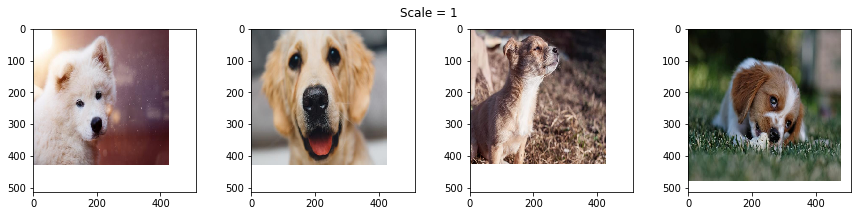

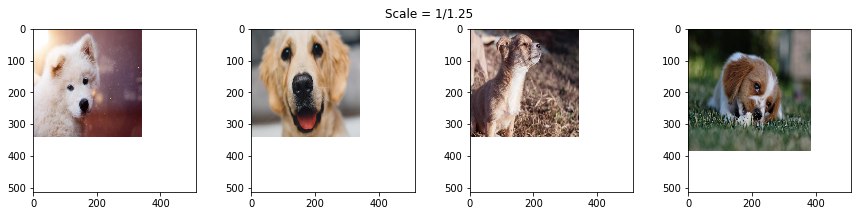

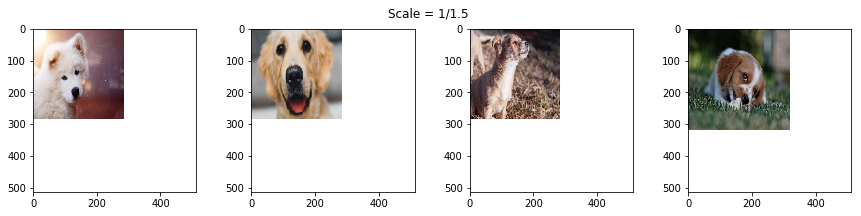

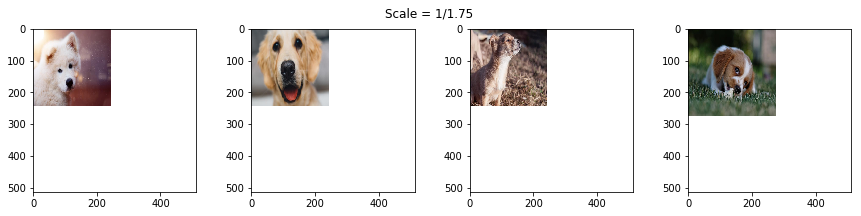

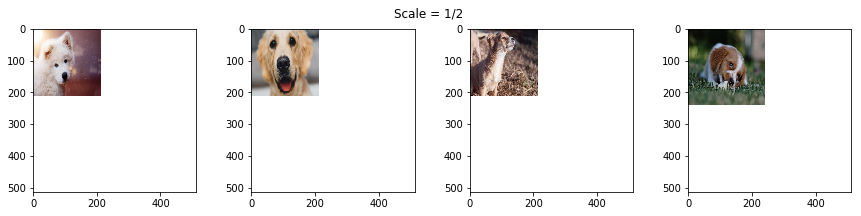

In [4]:
output = pipe.run()
for i in range(len(output)):
    display_batch(output[i], titles[i])